# WILDFIRE MITIGATION AND TOTAL COST

Certain states in the United States such as Colorado and California have experienced enormous losses because of wildfires. The pandemic of wildfires in recent years has resulted in deaths of thousands of people, increases in home-insurance premium and utility bills, and economic downtrends as people move out of areas affected by fires. The causes for wildfires are different. In some places, dangerous fires are wind-driven whereas others are fuel driven. Both federal and state governments spend billions of dollars on managing wildfires with a large portion of this cost being spent on suppression of wildfires.

Research shows that money put towards preparation purposes such as structure hardening of buildings, introducing fuel breaks for community level protection, and creating low intensity prescribed wildfires will reduce the post-wildfire cost impact by six times. Predicting wildfire and total cost will help the government and investors to spend money efficiently in fighting fires and dealing with their potential impacts.

One of the objective of this project is to forecast total cost. 

Data was extracted from NIFC[1] and NASF[2] websites. Since the data was recorded by different agencies there wasn't any common key on which these could be merged. Therefore a combination of DiscoveryDate, County and State are used to merge the datasets. 

In the merged data there were some helful features like suppression cost(EstimatedCost), number of structures destroyed, county, state. 

Total damaged structure cost was calculated by multiplying the total number of structures destroyed by the average home cost values.

In this notebook I will be loading the merged data, performing some EDA and creating a model to predict total structures destroyed and finally calculate damage cost. 

## Structure Damage Cost Prediction

### Load necessary Packages

In [32]:
import pandas as pd
import numpy as np
from time import time
from scipy import stats
import math
from datetime import datetime as dt

#==========================================
# EDA Reporting
from pandas_profiling import ProfileReport

#==========================================
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#==========================================

# Pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer,OrdinalEncoder

# CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import RFE

#=========================================

# Models

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Metrics

from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error, adjusted_rand_score

#=============================================

# To display all the features in a dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)

#==========================================

import warnings
warnings.filterwarnings('ignore')

## Load Data

Data is stored in the "data" folder

In [2]:
nifc_raw = pd.read_csv("data/new_merge_nasf_nicf.csv", parse_dates=['FireDiscoveryDateTime', 'FireToDate'])

In [4]:
nifc_raw.head(2)

,UniqueFireIdentifier,IncidentName,FireDiscoveryDateTime,FireCause,DailyAcres,EstimatedCostToDate,FireMgmtComplexity,FireToDate,POOCounty,POOState,POOLandownerKind,IncidentTypeCategory,PredominantFuelGroup,FireDiscoveryYear,FireDiscoveryMonth,key,Residences Threatened,Residences Destroyed,Other Structures Threatened,Other Structures Destroyed,Number Injuries,Number Fatalities,Final Fire Acre Quantity
0,2020-TXTXS-200317,Park,2020-07-21 22:37:08+00:00,Human,512.0,1.0,Type 5 Incident,2020-07-22 12:00:00+00:00,Shackelford,US-TX,Private,WF,NaN,2020,7,2020-07-21TXSHACKELFORD,0.0,0.0,0.0,0.0,0.0,0.0,512.0
1,2016-FLFLS-2016120122,Quincy,2016-03-09 19:30:00+00:00,Human,45.0,0.0,Type 5 Incident,2016-03-18 12:59:59+00:00,Brevard,US-FL,NaN,WF,NaN,2016,3,2016-03-09FLBREVARD,0.0,0.0,0.0,0.0,0.0,0.0,45.0


**Features**

* IncidentName - Name of the incident
* FireDiscoveryDateTime - Datetime at which the fire is discovered
* FireCause - Cause of the fire - Human, Natural, Unknown, Undetermined
* DailyAcres - Total acres burnt
* EstimatedCostToDate - Suppression cost
* FireMgmtComplexity - Complexity of fire management "Type 1" is most dangerous
* FireToDate - To date
* POOCounty - County
* POOState - State
* POOLandownerKind - Landowner kind whether federal or private properties
* IncidentTypeCategory - WF(wildfire), CX(complex), RX(Prescribed)
* PredominantFuelGroup - Fuel group for the fire - eg: timber, grass
* Residences Threatened - Threatened residence
* Residences Destroyed - Destroyed residences
* Other Structures Threatened - Structures threatened
* Other Structures Destroyed - Structures destroyed
* Number Injuries - Number of people injured
* Number Fatalities - Number of deaths
* Final Fire Acre Quantity - similar to Daily acres but most of the rows are NaNs.So ignore
* key, UniqueFireIdentifier - Identifiers for different agencies

## Preprocessing

In [3]:
nifc_merge = nifc_raw.copy()
nifc_merge['total_str_damaged'] = nifc_merge['Residences Destroyed'] + nifc_merge['Other Structures Destroyed']
nifc_merge['total_str_threatened'] = nifc_merge['Residences Threatened'] + nifc_merge['Other Structures Threatened']
nifc_merge.drop(['Residences Destroyed', 'Other Structures Destroyed', 'Residences Threatened', 'Other Structures Threatened'], inplace=True, axis=1)
nifc_merge['TotalDays'] = (nifc_merge['FireToDate'].dt.date - nifc_merge['FireDiscoveryDateTime'].dt.date).dt.days

## Data analysis

A basic analysis of the data can be done using pandas.profiling.

Note: If to_widgets gives error uninstall pandas_profiling, update anaconda and reinstall pandas profiling[4]


In [4]:
# Create  a report with basic analysis of data and save as html
#==================================================================

prof = ProfileReport(nifc_merge)
prof.to_widgets()

# Execute the following code to save the report in a html file
# prof.to_file(output_file='nifc_final_analysis.html')

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Found some negative values in the total days so dropping those columns
# For some rows Todate is missing and so filling those TotalDays with zeros
#==========================================================================

nifc_merge = nifc_merge[~(nifc_merge.TotalDays <0)]
nifc_merge.TotalDays.fillna(0,inplace=True)

<AxesSubplot:xlabel='IncidentTypeCategory', ylabel='DailyAcres'>

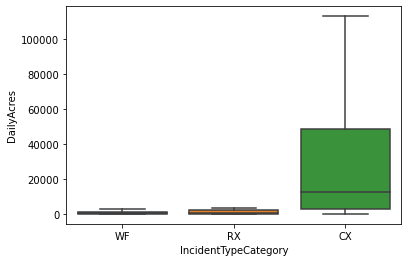

In [6]:
sns.boxplot(data=nifc_merge, y='DailyAcres', x='IncidentTypeCategory', showfliers = False)

The incident type CX(complex) has more acres burnt

In [7]:
nifc_merge[['FireMgmtComplexity', 'total_str_damaged']].groupby(['FireMgmtComplexity']).agg(['count','mean', 'sum'])

total_str_damaged                   
                                   count       mean     sum
FireMgmtComplexity                                         
Type 1 Incident                       67  18.641791  1249.0
Type 2 Incident                       88  41.420455  3645.0
Type 2 Prescribed Fire                 0        NaN     0.0
Type 3 Incident                      699   5.975680  4177.0
Type 4 Incident                     1614   1.845725  2979.0
Type 5 Incident                     1689   0.751924  1270.0

We do not have any data on prescribed fire. We have more data on type4 and type5 data. But for those categories the structure destruction is comparitively less comapred to other categories.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Type 5 Incident'),
  Text(1, 0, 'Type 3 Incident'),
  Text(2, 0, 'Type 4 Incident'),
  Text(3, 0, 'Type 2 Incident'),
  Text(4, 0, 'Type 1 Incident'),
  Text(5, 0, 'Type 2 Prescribed Fire')])

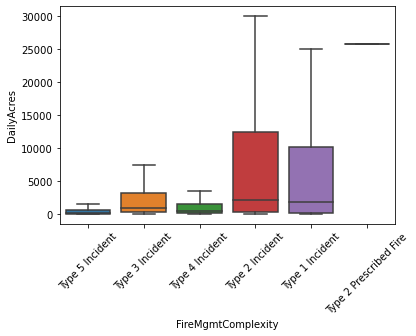

In [8]:
sns.boxplot(data=nifc_merge, y='DailyAcres', x='FireMgmtComplexity', showfliers = False)
plt.xticks(rotation=45)

Acres burnt for type2 and type1 are high too

#### Skewness of data

<AxesSubplot:xlabel='DailyAcres', ylabel='Density'>

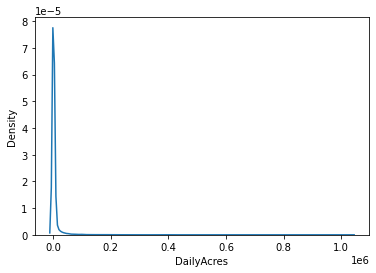

In [9]:
sns.kdeplot(data=nifc_merge, x='DailyAcres')

<AxesSubplot:xlabel='total_str_threatened', ylabel='Density'>

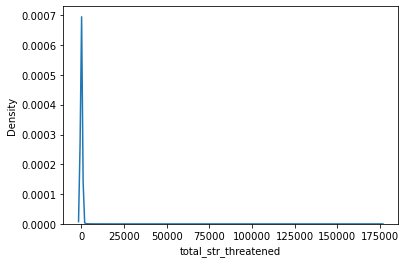

In [10]:
sns.kdeplot(data=nifc_merge, x='total_str_threatened')

The features acres burnt and structures threatened are right skewed. Therefore we are using a log transformation in the model pipeline

## Model

### Split numerical and categorical variables

In [11]:
target = 'total_str_damaged'

From the analysis report "PredominantFuelGroup" doesn't have much values and so can be dropped. 

In [12]:
ignore_vars = ['key', 'UniqueFireIdentifier', 'IncidentName', 'FireDiscoveryDateTime', 'X', 'Y', 
               'Final Fire Acre Quantity', 'avg_home_value', 'EstimatedCostToDate', 'total_cost_damaged', 'PredominantFuelGroup',
              'FireToDate', 'Number Fatalities', 'Number Injuries']

cat_vars =  list(set(nifc_merge.select_dtypes(include='object').columns) - set(ignore_vars))
numeric_vars = list(set(nifc_merge.columns) - set(cat_vars) - set(ignore_vars))
print(f"Categorical Variables are {cat_vars}")
print("============================================")
print(f"Numeric Variables are {numeric_vars}")

Categorical Variables are ['POOLandownerKind', 'FireCause', 'POOState', 'FireMgmtComplexity', 'IncidentTypeCategory', 'POOCounty']
Numeric Variables are ['total_str_threatened', 'TotalDays', 'DailyAcres', 'FireDiscoveryYear', 'total_str_damaged', 'FireDiscoveryMonth']


In [13]:
numeric_vars = list(set(numeric_vars) - set([target]))
numeric_vars

['total_str_threatened',
 'TotalDays',
 'DailyAcres',
 'FireDiscoveryYear',
 'FireDiscoveryMonth']

## Pipelines

### Feature selector pipeline

The pipeline to select specific features only

In [14]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Since we found that numeric features are righ skewed we are introducing log transformation to make the features normal. 

In [15]:
def log_transform(x):
    return np.log(x + 1) 

transformer = FunctionTransformer(log_transform)

### Numeric or Categorical pipeline

In [16]:
# Create a pipeline for the numeric features.
# Use DataFrameSelector with the numeric features defined above
# Use StandardScaler() to standardize the data
# Missing values will be imputed using the feature median.

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_vars)),
        ('imputer', SimpleImputer(strategy='median')),
        ('log_trans', transformer),
        ('std_scaler', StandardScaler()),
    ])

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
# defined above will be one hot encoded as zeroes.

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_vars)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

In [17]:
# Union the transformed, scaled numeric and categorical features.
data_prep_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

## Model Prep

In [18]:
random_state = 222 #42
CV_Splits = 2

### Split data

In [19]:
nifc_merge.total_str_damaged.isna().sum()

8525

In [20]:
# nifc_merge['total_str_damaged'].fillna(0, inplace=True)
nifc_merge.dropna(subset = ['total_str_damaged'], inplace=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(nifc_merge.drop([target], axis=1), nifc_merge[[target]],test_size=.2, random_state=random_state)

In [22]:
print(f"Size of Train X is {X_train.shape}")
print(f"Size of Train y is {y_train.shape}")
print(f"Size of Test X is {X_test.shape}")
print(f"Size of Test y is {y_test.shape}")

Size of Train X is (3704, 21)
Size of Train y is (3704, 1)
Size of Test X is (927, 21)
Size of Test y is (927, 1)


### Results log

Initialize the results log

In [23]:
if False: # Make True only if running for the first time (To prevent reset of results)
    results = pd.DataFrame(columns=["ExpID", "Model", 
                                'train_R2_Score', "test_R2_Score", "train_RMSE", "test_RMSE", "train_MAE", "test_MAE",
                                "fit_time", "score_time", "Parameters"])

In [24]:
def display_results(model_name,scores, best_params= None):
    i = len(results) 
    results.loc[i, "ExpID"] = i +1
    results.loc[i, "Model"] = model_name #+ str(random_state)
    results.loc[i, "fit_time"] = scores["fit_time"][0]
    results.loc[i, "score_time"] = scores["score_time"][0]
    results.loc[i, "test_R2_Score"] = scores["test_R2_Score"][0]
    results.loc[i, "train_R2_Score"] = scores["train_R2_Score"][0]
    results.loc[i, "test_RMSE"] = math.sqrt(scores["test_MSE"][0])
    results.loc[i, "train_RMSE"] = math.sqrt(scores["train_MSE"][0])
    results.loc[i, "test_MAE"] = scores["test_MAE"][0]
    results.loc[i, "train_MAE"] = scores["train_MAE"][0]
    results.loc[i, "Parameters"] = best_params
    

### Scores

Set the metric scores here

In [25]:
scorers = {'R2_Score': make_scorer(r2_score),
           'MSE': make_scorer(mean_squared_error),
           'MAE': make_scorer(mean_absolute_error)
          }

## Models

### Baseline Simple Linear Regression

#### Set up Pipeline

In [26]:
np.random.seed(random_state)

baseline_pipeline = Pipeline([
    ('preperation', data_prep_pipeline),
     ('baseline_rfr', RandomForestRegressor(n_estimators=50, max_depth = 10, max_features=8))
])

#### Run Predictions

In [27]:
np.random.seed(random_state)

baseline_pipeline.fit(X_train, y_train)
start = time()
linear_test_pred = baseline_pipeline.predict(X_test)
train_time = np.round(time() - start, 4)

In [28]:
linear_train_scores = cross_validate(baseline_pipeline, X_train, y_train, cv=CV_Splits, scoring=scorers, return_train_score=True, n_jobs=-1)


In [29]:
# If error occurs stating "results not found", in the results log section enable the dataframe intialization
display_results('baseline', linear_train_scores)

In [30]:
results

,ExpID,Model,train_R2_Score,test_R2_Score,train_RMSE,test_RMSE,train_MAE,test_MAE,fit_time,score_time,Parameters
0,1,baseline,0.347856,0.043822,379.552015,460.347449,21.250336,24.897694,0.134614,0.034138,None


### Grid Search - Complex models

### Parameters

In [33]:
# Define models
reg_models =  [
        ('Random Forest', RandomForestRegressor(random_state=random_state)),
    ('ElasticNet', ElasticNet(random_state=random_state)),
    ('LightGBM', LGBMRegressor(random_state=random_state))
    ]

In [35]:
# Set up different paramters for gridsearch
params_grid = {
        'Random Forest': {
            'n_estimators' : [25, 50, 100, 150], 
            'max_depth' : [5, 10, 20, 25], 
            'max_features' : [8, 10, "auto"],
            'min_weight_fraction_leaf' : [0, 2, 5, 10],            
        },
    'ElasticNet':{
        'alpha' : [0, 1, 2],
        'l1_ratio' : [0, .5, 1, 1.5, 2]
    },
    
    'LightGBM' : {
        'boosting_type ' : ['gbdt', 'dart', 'goss', 'rf'],
            'max_depth': [-1, 5, 10], # Lower helps with overfitting
            'num_leaves': [5, 10, 20, 25, 30, 35, 40],
            'n_estimators':[100, 500, 1000],
            'learning_rate': [0.01, .1, .001],
    }
    }

In [36]:
for (name, reg_model) in reg_models:
    
     # Execute the grid search
    params = {}
    for p in params_grid[name].keys():
        pipe_key = 'predictor__'+str(p)
        params[pipe_key] = params_grid[name][p] 
    
    print(f"#=========Starting {name} model===============#")
   # generate the pipeline
    full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("predictor", reg_model)
    ])
    
    grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring=scorers, cv=CV_Splits, verbose=1, n_jobs=-1, refit="R2_Score")
    grid_search.fit(X_train, y_train)
    
    print("#========Grid Search Ended==========#")
    print()
    
    print(f"Best parameters selected by gridsearch are:")
    print(grid_search.best_params_)
    
    gridsearch_r2 = grid_search.best_score_
    
    print()
    print(f"#===Evaluating best fit {name} model using cross validation =====#")
    
    best_train_scores = cross_validate(grid_search.best_estimator_, 
                                       X_train, y_train, cv=CV_Splits, scoring=scorers, return_train_score=True, n_jobs=-1, verbose =1)
    
    
    print(f"#===Evaluation ended =====#")
    print()
    
#     print("Scores of cross validation are:")
    
    display_results(name, best_train_scores, str(grid_search.best_params_))
    
    gs_pred = grid_search.best_estimator_.predict
    
    
    
    

#=========Starting Random Forest model===============#
Fitting 2 folds for each of 192 candidates, totalling 384 fits
#========Grid Search Ended==========#

Best parameters selected by gridsearch are:
{'predictor__max_depth': 20, 'predictor__max_features': 'auto', 'predictor__min_weight_fraction_leaf': 0, 'predictor__n_estimators': 100}

#===Evaluating best fit Random Forest model using cross validation =====#


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   15.8s finished


#===Evaluation ended =====#

#=========Starting ElasticNet model===============#
Fitting 2 folds for each of 15 candidates, totalling 30 fits
#========Grid Search Ended==========#

Best parameters selected by gridsearch are:
{'predictor__alpha': 1, 'predictor__l1_ratio': 0.5}

#===Evaluating best fit ElasticNet model using cross validation =====#


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished


#===Evaluation ended =====#

#=========Starting LightGBM model===============#
Fitting 2 folds for each of 756 candidates, totalling 1512 fits
[LightGBM] [Warning] boosting_type is set=gbdt, boosting_type= will be ignored. Current value: boosting_type=gbdt
[LightGBM] [Warning] Unknown parameter: gbdt
#========Grid Search Ended==========#

Best parameters selected by gridsearch are:
{'predictor__boosting_type ': 'gbdt', 'predictor__learning_rate': 0.1, 'predictor__max_depth': -1, 'predictor__n_estimators': 500, 'predictor__num_leaves': 10}

#===Evaluating best fit LightGBM model using cross validation =====#


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


#===Evaluation ended =====#



[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s finished


In [37]:
results

,ExpID,Model,train_R2_Score,test_R2_Score,train_RMSE,test_RMSE,train_MAE,test_MAE,fit_time,score_time,Parameters
0,1,baseline,0.347856,0.043822,379.552015,460.347449,21.250336,24.897694,0.134614,0.034138,None
1,2,Random Forest,0.883821,0.661319,160.200473,273.975494,7.863969,12.920641,15.698301,0.087922,"{'predictor__max_depth': 20, 'predictor__max_f..."
2,3,ElasticNet,0.033519,0.032262,462.057828,463.121954,47.209889,48.096431,0.083999,0.046354,"{'predictor__alpha': 1, 'predictor__l1_ratio':..."
3,4,LightGBM,0.831645,0.77606,192.84681,222.782991,22.215772,27.850316,0.379275,0.201462,"{'predictor__boosting_type ': 'gbdt', 'predict..."


Let us see how good our LightGBM model predictions are on the test data

In [38]:
gs_best = grid_search.best_estimator_.fit(X_train, y_train)
gs_pred = gs_best.predict(X_test)

Some of the values are predicted negative so we assign those values to zeros and then find adjusted r2, rmse and mae values

In [39]:
gs_pred[gs_pred < 0] = 0

In [40]:
adj_r2 = 1 - (1-grid_search.best_estimator_.score(X_train, y_train))*(len(y_test)-1)/(len(y_test)-X_train.shape[1]-1)
print(f"Adjusted R2 value is {adj_r2}")

Adjusted R2 value is 0.9330021992592359


In [41]:
print(f"rmse is {np.sqrt(mean_squared_error(y_test, gs_pred))} and mae is {mean_absolute_error(y_test, gs_pred)}")

rmse is 57.77000315885087 and mae is 9.032157574933223


The lightgbm model is a good model as we have an adjusted r2 value of .93 and very small rmse and mae values. 

## Results

After removing features like number of fatalities and number of injuries LightGBM model gave a good R2 score of .83 and .77 and rmse in few hundreds. 

As we can see in the analysis, the target variable is having about 64% of missing values. Many other features are also having high missing values. We tried different strategies like 
* changing random states for testtrain splits, 
* changing scaling methods(used StandardScalar, MinMaxScalar), 
* changing imputation methods(tried either dropping nulls or imputing with other values), 
* excluding and including feature ( For example removing features that have more missing values like number of injuries, number of fatalities etc. 

## References

1. NIFC data <https://data-nifc.opendata.arcgis.com/>
2. NASF data <https://famprod.nwcg.gov/cognos11/bi/?perspective=home>
3. USFS data <https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.Fire_Occurrence_FIRESTAT_YRLY.zip>
4. Solving pandas profiling issue <https://github.com/ydataai/pandas-profiling/issues/836>
